# Data Sources:
- Antarctica: https://nsidc.org/data/nsidc-0709/versions/2
  - Mouginot, J., B. Scheuchl, and E. Rignot. (2017). MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar, Version 2. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/AXE4121732AD.
- Greenland: https://datadryad.org/stash/dataset/doi:10.7280/D1WT11
  - Mouginot, Jeremie; Rignot, Eric (2019), Glacier catchments/basins for the Greenland Ice Sheet, Dryad, Dataset, https://doi.org/10.7280/D1WT11

In [1]:
%matplotlib widget
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cmc
from shapely.geometry import Polygon

# Plot of data

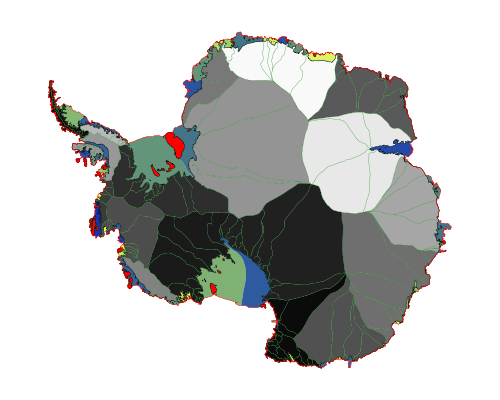

In [2]:
fig, ax = plt.subplots(figsize=[5,4])

fn = 'Basins_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.loc[gdf.NAME=='Islands','Subregions'] = 'Islands'
gdf.plot(column='Subregions', cmap=cmc.grayCS, ax=ax)
gdf[gdf.NAME=='Islands'].plot(color='r', ax=ax)
gdf.boundary.plot(color='g', ax=ax, lw=0.1)

fn = 'IceShelf_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.plot(column='NAME', cmap=cmc.imolaS, ax=ax)

fn = 'GroundingLine_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.boundary.plot(color='k', ax=ax, lw=0.3)

fn = 'Coastline_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.boundary.plot(color='r', ax=ax, lw=0.3)

ax.axis('off')
fig.tight_layout()

In [3]:
# issues with ice shelves: 
# - there are two "Fox" ice shelves: rename to Fox_East and Fox_West (according to Regions)
# - Moscow_University is called Moscow in Shelf_Assoc: Rename to Moscow_University
# - Wordie has 5 entries --> assign Wordie_(Cape_Jeremy) to Hp-I and others to 

fn = 'Basins_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.loc[gdf.NAME=='Islands','Subregions'] = 'Islands'
def get_shelves_list(x):
    try: return x.Asso_Shelf.split('/')
    except: return []
gdf['Asso_Shelf'] = gdf.apply(get_shelves_list, axis=1)
gdf_regions = gdf.dissolve('Subregions')[['Regions', 'geometry']]
regions_group = gdf.groupby(by="Subregions")
gdf_regions['shelves'] = regions_group['Asso_Shelf'].apply(lambda x: np.unique([item for sub in x for item in sub if item]))
gdf_regions.reset_index(inplace=True)
gdf_regions['NAME'] = gdf_regions.Subregions
gdf_regions['TYPE'] = 'GR'

fn = 'IceShelf_Antarctica_v02.shp'
gdf_shelf = gpd.read_file(fn)
gdf_shelf.loc[gdf_shelf.NAME == 'Fox', 'NAME'] = gdf_shelf.loc[gdf_shelf.NAME == 'Fox'].apply(lambda x: '%s_%s' % (x.NAME, x.Regions), axis=1)
gdf_shelf.set_index('NAME', inplace=True)

shlvs = []
for i in range(len(gdf_regions)):
    r = gdf_regions.iloc[i]
    for shelf in r.shelves:
        if shelf == 'Fox': shelf = '%s_%s' % (shelf, r.Regions)
        if shelf == 'Moscow': shelf = 'Moscow_University'
        if shelf == 'Ronne_Ice': shelf = 'Ronne'
        if shelf == 'Wordie':
            if r.Subregions == 'Hp-I':
                wordies = ['Wordie_(Cape_Jeremy)']
            elif r.Subregions == 'I-Ipp': 
                wordies = ['Wordie_(Prospect)','Wordie_(Airy_Rotz_Seller)','Wordie_(Harriott_Headland)','Wordie_(Harriott)']
            for wordie_part in wordies:
                sh = gdf_shelf.loc[wordie_part]
                gdf_regions.loc[len(gdf_regions)] = [r.Subregions, sh.Regions, sh.geometry, np.nan, wordie_part, sh.TYPE]
                shlvs.append(wordie_part)
        else:
            sh = gdf_shelf.loc[shelf]
            gdf_regions.loc[len(gdf_regions)] = [r.Subregions, sh.Regions, sh.geometry, np.nan, shelf, sh.TYPE]
            shlvs.append(shelf)

gdf_regions.drop('shelves', axis=1, inplace=True)
gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands'].copy()

# add each island to the subregion (including shelves) that overlaps most with the island's boundary
for geom in gdf_regions[gdf_regions.NAME == 'Islands'].iloc[0].geometry.geoms:
    r = gdf_merged[gdf_merged.intersects(geom.boundary)]
    if len(r) > 0:
        if len(r) > 1:
            r = r.iloc[r.intersection(geom.boundary).length.argmax()]
        else:
            r = r.iloc[0]
        gdf_regions.loc[len(gdf_regions)] = [r.Subregions, r.Regions, geom, 'island', 'IS']

gdf_merged = gdf_regions.dissolve('Subregions')[['Regions', 'geometry']].reset_index()
gdf_merged = gdf_merged[gdf_merged.Subregions != 'Islands'].copy()

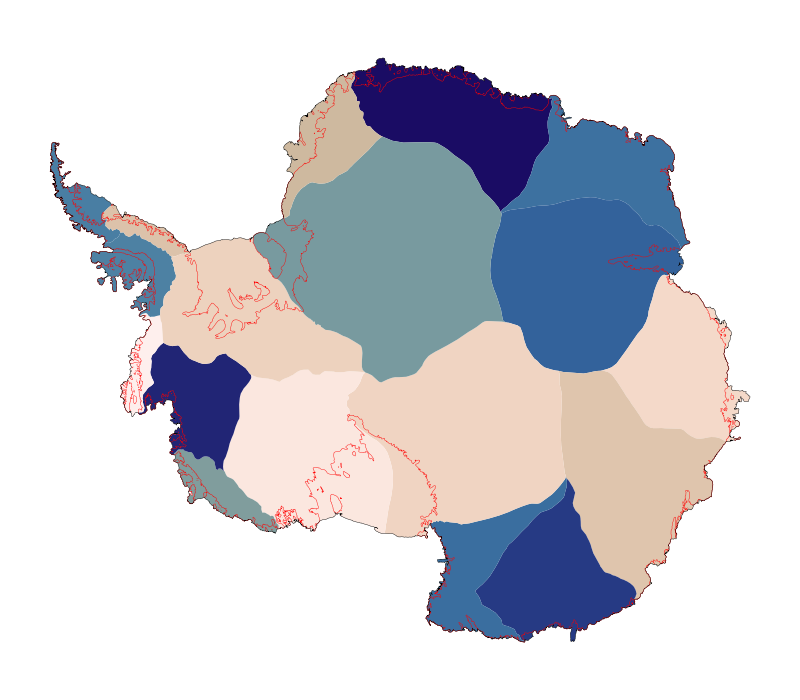

In [4]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_merged.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)

fn = 'GroundingLine_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.boundary.plot(color='r', ax=ax, lw=0.3)

fn = 'Coastline_Antarctica_v02.shp'
gdf = gpd.read_file(fn)
gdf.boundary.plot(color='k', ax=ax, lw=0.3)

ax.axis('off')
fig.tight_layout()

<Axes: >

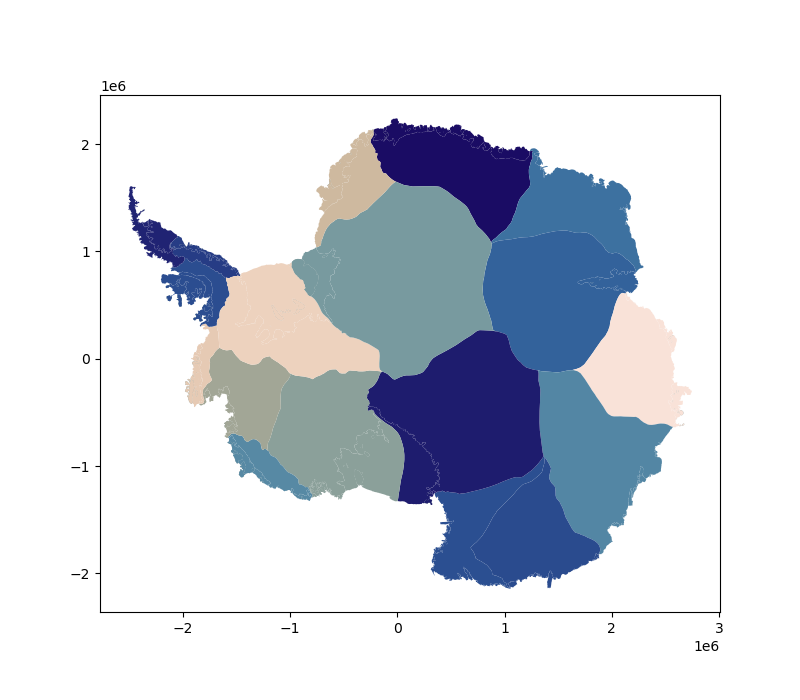

In [5]:
fig, ax = plt.subplots(figsize=[8,7])
gdf_regions.plot(column='Subregions', cmap=cmc.lapazS, ax=ax)

# Greenland Basins

,SUBREGION1,NAME,GL_TYPE,geometry
0,NW,UMIAMMAKKU_ISBRAE,TW,"POLYGON ((-250013.970 -1962482.806, -250392.42..."
1,CE,GEIKIE_UNNAMED_VESTFORD_S,TW,"POLYGON ((669064.856 -2093802.344, 668921.855 ..."
2,CW,RINK_ISBRAE,TW,"POLYGON ((245236.056 -1890271.273, 242838.452 ..."
3,CW,KANGERLUSSUUP_SERMERSUA,TW,"POLYGON ((245014.582 -1891216.649, 240674.780 ..."
4,CW,CW_NONAME3,LT,"POLYGON ((-196828.245 -2054377.448, -197638.91..."


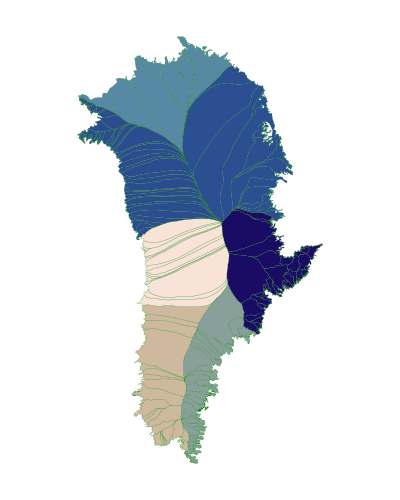

In [6]:
fig, ax = plt.subplots(figsize=[4,5])

fn = 'Greenland_Basins_PS_v1.4.2.shp'
gdf = gpd.read_file(fn)
is_ice_cap = gdf.apply(lambda x: 'ICE_CAPS' in x.NAME, axis=1)
gdf = gdf[~is_ice_cap]
gdf.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
# gdf.plot(column='GL_TYPE', cmap=cmc.hawaiiS, ax=ax)
gdf.boundary.plot(color='g', ax=ax, lw=0.1)

ax.axis('off')
fig.tight_layout()

gdf.head()

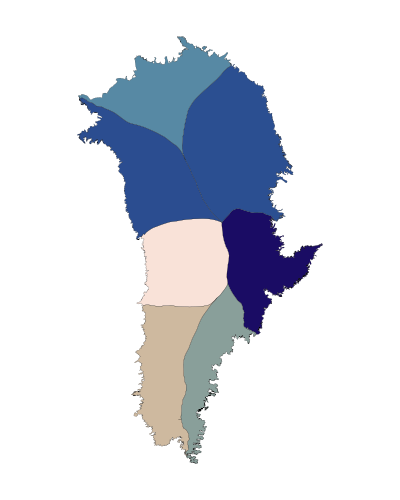

In [7]:
gdf_regions = gdf.dissolve('SUBREGION1').reset_index()
fig, ax = plt.subplots(figsize=[4,5])
def close_holes(poly):
        if poly.interiors: return Polygon(list(poly.exterior.coords))
        else: return poly
# gdf_regions['geometry'] = gdf_regions.geometry.apply(lambda x: x.simplify(1000))
gdf_regions['geometry'] = gdf_regions.geometry.apply(lambda x: close_holes(x))
gdf_regions.plot(column='SUBREGION1', cmap=cmc.lapazS, ax=ax)
gdf_regions.boundary.plot(color='k', ax=ax, lw=0.1)

ax.axis('off')
fig.tight_layout()